In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
cd '/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER'

/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER


In [3]:
import MatrixNTM

In [4]:
cd 'SavedModels/RNNMatNTM_AssRec1/Train4'

/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER/SavedModels/RNNMatNTM_AssRec1/Train4


In [5]:
MNTM = torch.load('MNTM.pth')

In [6]:
MNTM.count_parameters()

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|      Controller.RNN.0.Connections.Up      |    400     |
|      Controller.RNN.0.Connections.Vp      |    400     |
|      Controller.RNN.0.Connections.Uq      |    100     |
|      Controller.RNN.0.Connections.Vq      |    100     |
|      Controller.RNN.0.Connections.Ur      |    120     |
|      Controller.RNN.0.Connections.Vr      |    120     |
|       Controller.RNN.0.Connections.B      |    400     |
|      Controller.RNN.1.Connections.Up      |    400     |
|      Controller.RNN.1.Connections.Vp      |    400     |
|      Controller.RNN.1.Connections.Uq      |    100     |
|      Controller.RNN.1.Connections.Vq      |    100     |
|      Controller.RNN.1.Connections.Ur      |    120     |
|      Controller.RNN.1.Connections.Vr      |    120     |
|       Controller.RNN.1.Connections.B      |    400    

7946

In [6]:
BATCH_SIZE = 16
INPUT_DIMS  = [5,5]
ITEM_SIZE = 2
DEVICE='cuda:0'

In [7]:
def OneBatchSequence(seq_size = [4,5], item_size = 2, num_items = 15, query_num = 14):
    
    assert num_items > query_num
    
    limiter = torch.zeros([seq_size[0]+1, seq_size[1]])
    limiter[-1,0] = 1.0
    limiter[-1,-1] = 1.0
    
    
    cat_list = []
    for i in range(num_items):
        
        cat_list.append(limiter)
        
        content = torch.rand([seq_size[0]+1, seq_size[1] * item_size])
        content[:-1,:][content[:-1,:] > 0.5] = 1.0
        content[-1,:] = 0.0
        content[content != 1] = 0.0
        cat_list.append(content)
        
    
    delimeter = torch.zeros([seq_size[0]+1, seq_size[1]])
    delimeter[-1,1:-1] = 1.0
    cat_list.append(delimeter)
    
    
    start = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2)
    stop = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2) + (seq_size[1]*2) 
    
    sequence = torch.cat(cat_list, dim = 1)
    
    query = sequence[:,start:stop]
    expected_result = sequence[:,start+3*seq_size[1] : stop+3*seq_size[1]]

    
    finalsequence = torch.cat([sequence, query], dim = 1)
            
    
    return finalsequence, expected_result




def GenRandBatchSeq(batch_size=32, seq_size = [4,5], item_size = 2, num_items = 15, device = None):
    
    seq_list = []
    res_list = []
    
    
    
    for i in range(batch_size):
        query_num = torch.randint(low=1, high=num_items, size=[])
        seq, res = OneBatchSequence(seq_size=seq_size, item_size=item_size, num_items=num_items, query_num=query_num)
        seq_list.append(seq.unsqueeze(0))
        res_list.append(res.unsqueeze(0))
    
    seq_tensor = torch.cat(seq_list, dim=0)
    res_tensor = torch.cat(res_list, dim=0)
    
    return seq_tensor.to(device), res_tensor.to(device)

def Bit_Seq_Error(output , target, batch_size, sequence_length):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0
    bit_error = torch.sum((torch.abs(target - bit_output)) )/(batch_size*sequence_length)
    return bit_error

loss_func = torch.nn.BCELoss()


In [8]:
def RunOneEpoch(num_items = 3, item_size = 2):
    
#     num_items = torch.randint(low=2, high=10, size=[],device=DEVICE)
    i=0
    ITEM_SIZE = item_size
    inp, out = GenRandBatchSeq(batch_size=BATCH_SIZE, seq_size=[INPUT_DIMS[0]-1,INPUT_DIMS[1]], item_size=ITEM_SIZE, num_items=num_items, device=DEVICE)
    #inp, out = MatrixCopyDataGen(32,[4,5],num_t)

    response_sheet = torch.zeros_like(out)

    print("Epoch: ",i)

    print("--->Number of Items: ",int(num_items))

    MNTM.HiddenReset()

    MNTM.zero_grad()

    #Feeding the sequence
    #Input sequence is of length inp.shape[2]/5 

    num_sequences = int(inp.shape[2]/INPUT_DIMS[1])

    ReadW_List = []
    WriteW_List = []
    Memories = []
    
    for t in range(1,num_sequences+1):
        _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
                                    #5 is the seq_size[1]   
        ReadW_List.append(MNTM.Controller.HO_Out[1][0][0].reshape(-1,1).detach().cpu())
        #                                        ^Read ^Batch
        WriteW_List.append(MNTM.Controller.HO_Out[2][0][0].reshape(-1,1).detach().cpu())
        Memories.append(MNTM.MemoryUnit.Memory[0].detach().cpu())

    #Taking Output from controller now, for backprop
    output = []
                    # 2 is the item_size
    for t in range(1,ITEM_SIZE+1):
        MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
        output.append(MNTM_out)
        ReadW_List.append(MNTM.Controller.HO_Out[1][0][0].reshape(-1,1).detach().cpu())
        #                                        ^Read ^Batch
        WriteW_List.append(MNTM.Controller.HO_Out[2][0][0].reshape(-1,1).detach().cpu())
        Memories.append(MNTM.MemoryUnit.Memory[0].detach().cpu())


    res = torch.cat(output, dim=2)

    loss = loss_func(res, out)

    bse = Bit_Seq_Error(res, out, BATCH_SIZE, ITEM_SIZE)

    print("----->Loss: {}".format(loss))
    print("----->Bit Sequence Error : {}".format(bse))
    print("--||--||--||--||--||--||--||--||--")
    
    inp_ = inp.clone().cpu()
    out_ = out.clone().cpu().detach()
    res_ = res.clone().cpu().detach()
    
    return bse, inp_, out_, res_, WriteW_List, ReadW_List, Memories

In [61]:
num_t = 6
item_size = 2
_,inp, out, res, WriteW_List, ReadW_List, Mems = RunOneEpoch(num_t, item_size)

Epoch:  0
--->Number of Items:  6
----->Loss: 0.0005925807054154575
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--


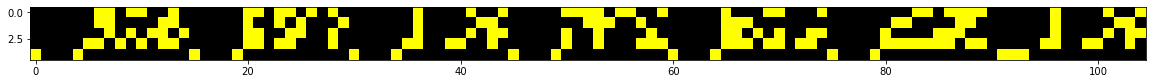

In [62]:
plt.figure(figsize=(20,12))
plt.imshow(inp[0][:,:],cmap='gnuplot')
plt.savefig('Input1.svg')

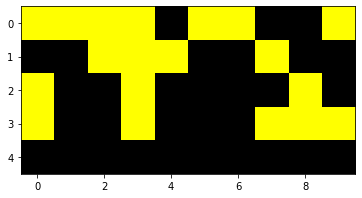

In [63]:
# plt.figure(figsize=(20,12))
plt.imshow(res[0][:,:],cmap='gnuplot')
plt.savefig('Output1.svg')

In [64]:
READW = torch.cat(ReadW_List,1)
WRITEW = torch.cat(WriteW_List,1)

JOINTW = torch.cat([WRITEW[:,:num_t+1], READW[:,num_t+1:]],1)

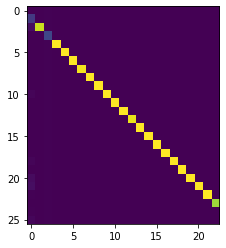

In [232]:
plt.imshow(WRITEW[79:105,:])
plt.savefig('WRITEW.svg')

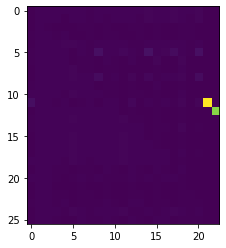

In [233]:
plt.imshow(READW[79:105,:])
plt.savefig('READW.svg')

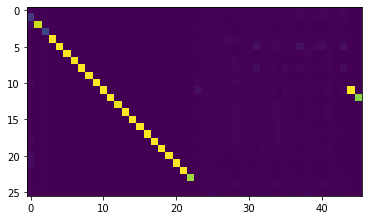

In [234]:
plt.imshow(torch.cat([WRITEW[79:105,:] , READW[79:105,:] ], 1))
# plt.colorbar()

In [242]:
MEM.shape

torch.Size([120, 6, 138])

In [244]:
Mems = torch.split(MEM, [6 for _ in range(23)], -1)

In [247]:
MEM = torch.cat(Mems, -1)
torch.save(MEM,'MEM')

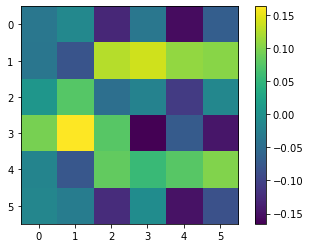

In [245]:
# plt.figure(figsize=(20,12))
i=0
plt.imshow(torch.cat(torch.split(Mems[i], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,480+i*6:486+i*6])
plt.colorbar()

<Figure size 1440x864 with 0 Axes>

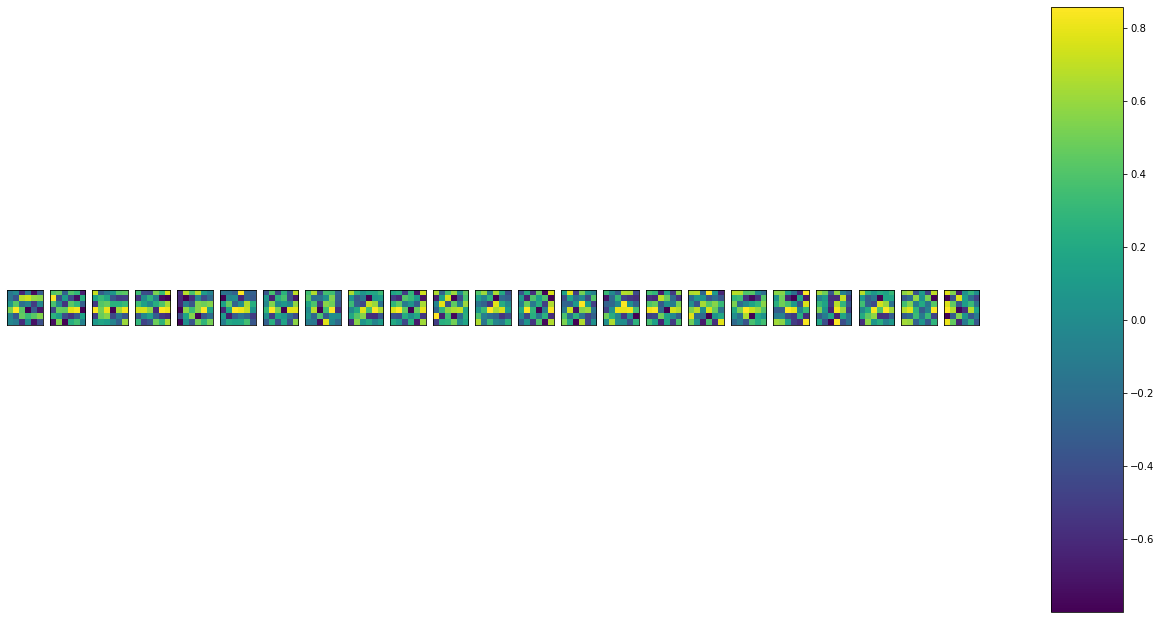

In [246]:
plt.figure(figsize=(20,12))

 # labels along the bottom edge are off

# plt.imshow(torch.cat(torch.split(Mems[4], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,:100])

fig, axes = plt.subplots(nrows=1, ncols=23, figsize=(20,12))



for i,ax in enumerate(axes.flat):
#     print(i)
    im = ax.imshow(torch.cat(torch.split(Mems[i], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,480+i*6:486+i*6])
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False
    
    )

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, )
fig.savefig('mem_repres.svg')

In [82]:
Mems[0].shape

torch.Size([120, 6, 6])

In [222]:

MultiBSEs = []

for i in range(5):
    BSEs = []
    for t in range(2,60):
        num_t = t
        item_size = 2
        bse, inp, out, res, WriteW_List, ReadW_List, Mems = RunOneEpoch(num_t, item_size)
        BSEs.append(float(bse))
    MultiBSEs.append(BSEs)


Epoch:  0
--->Number of Items:  2
----->Loss: 0.0006918269209563732
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  3
----->Loss: 0.00014213153917808086
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  4
----->Loss: 0.00015797851665411144
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  5
----->Loss: 0.000157046495587565
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  6
----->Loss: 0.0001326390920439735
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  7
----->Loss: 0.008696422912180424
----->Bit Sequence Error : 0.09375
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  8
----->Loss: 0.00010966157424263656
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  9
----->Loss: 0.000140838

----->Loss: 0.0008933983626775444
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  8
----->Loss: 0.00041785085340961814
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  9
----->Loss: 0.0004538589855656028
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  10
----->Loss: 0.0003742197004612535
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  11
----->Loss: 0.0017262189649045467
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  12
----->Loss: 0.00015468352648895234
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  13
----->Loss: 0.0049127996899187565
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  14
----->Loss: 0.000378352910047397
----->Bit Sequence Err

----->Loss: 0.00015956127026584
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  12
----->Loss: 0.008265739306807518
----->Bit Sequence Error : 0.09375
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  13
----->Loss: 0.00034143420634791255
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  14
----->Loss: 0.0011036198120564222
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  15
----->Loss: 0.0001579483796376735
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  16
----->Loss: 0.0055656423792243
----->Bit Sequence Error : 0.03125
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  17
----->Loss: 0.01758696883916855
----->Bit Sequence Error : 0.28125
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  18
----->Loss: 0.0005446080467663705
----->Bit Sequen

Epoch:  0
--->Number of Items:  15
----->Loss: 0.00015573528071399778
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  16
----->Loss: 0.001709143747575581
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  17
----->Loss: 0.04873182252049446
----->Bit Sequence Error : 0.53125
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  18
----->Loss: 0.0005394710460677743
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  19
----->Loss: 0.0003212763404008001
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  20
----->Loss: 0.0006652830634266138
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  21
----->Loss: 0.006738737225532532
----->Bit Sequence Error : 0.0625
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  22
----->Loss: 0.02

----->Loss: 0.06545888632535934
----->Bit Sequence Error : 0.65625
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  19
----->Loss: 0.0072863041423261166
----->Bit Sequence Error : 0.03125
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  20
----->Loss: 0.006274685729295015
----->Bit Sequence Error : 0.03125
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  21
----->Loss: 0.019613828510046005
----->Bit Sequence Error : 0.1875
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  22
----->Loss: 0.002232556464150548
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  23
----->Loss: 0.0025440140161663294
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  24
----->Loss: 0.09858813881874084
----->Bit Sequence Error : 0.625
--||--||--||--||--||--||--||--||--
Epoch:  0
--->Number of Items:  25
----->Loss: 0.12095076590776443
----->Bit Seq

In [195]:
len(MultiBSEs[0])

58

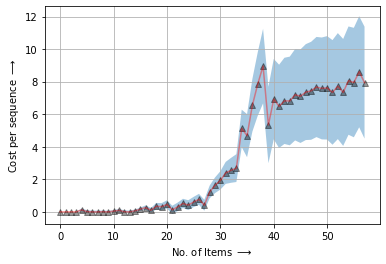

In [230]:
avgBSE = []
maxBSE = []
minBSE = []

y = []
for t in range(0,58):
    x=0
    for i in range(5):
        x += MultiBSEs[i][t]
        y.append(MultiBSEs[i][t])
    avgBSE.append(float(x/5))
    maxBSE.append(float(x/5 + np.std(y)))
    minBSE.append(float(x/5 - np.std(y)))

xr = [i for i in range(58)]
    
spl = make_interp_spline(xr, avgBSE, k=3)  # type: BSpline
power_smooth = spl(xr)

plt.plot(power_smooth,'^',color='black',alpha = 0.4)
plt.plot(power_smooth,alpha=0.4,color='red')
plt.fill_between(x = xr, y1 = minBSE, y2 = maxBSE,interpolate=True, alpha = 0.4)
# plt.plot(x=[10,10],y=[0,8.5])
plt.grid()
plt.xlabel('No. of Items $\longrightarrow$')
plt.ylabel('Cost per sequence $\longrightarrow$')
        
# plt.plot(MultiBSEs[0],'^',color='black',alpha = 0.7)
# plt.plot(MultiBSEs[0],alpha=0.4)
# # plt.plot(x=[10,10],y=[0,8.5])
# plt.grid()
# plt.xlabel('No. of Items $\longrightarrow$')
# plt.ylabel('Cost per sequence $\longrightarrow$')

plt.savefig('BSEonHighItems.svg')


In [210]:
x = np.load('MultiBSEs.npy',allow_pickle=True)

In [216]:
minBSE

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]